In [3]:
from lagom.value_functions import StateValueHead

StateValueHead()

/home/zuo/anaconda3/envs/RL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zuo/Code/lagom/lagom/vis/__init__.py:10: UserWarning: ImageViewer failed to import due to pyglet. 
  warnings.warn('ImageViewer failed to import due to pyglet. ')
/home/zuo/Code/lagom/lagom/envs/vec_env/vec_env.py:12: UserWarning: ImageViewer failed to import due to pyglet. 
  warnings.warn('ImageViewer failed to import due to pyglet. ')


In [4]:
from pathlib import Path
from lagom.experiment import Configurator

from lagom.utils import pickle_load

from lagom.vis import CurvePlot

In [5]:
log_folder = Path('logs')

list_config = pickle_load(log_folder/'configs.pkl')
configs = Configurator.to_dataframe(list_config)
configs

,ID,cuda,env.id,env.standardize,network.recurrent,network.hidden_sizes,algo.lr,algo.use_lr_scheduler,algo.gamma,agent.standardize_Q,...,agent.constant_std,agent.std_state_dependent,agent.init_std,train.timestep,train.N,train.T,eval.N,log.record_interval,log.print_interval,log.dir
0,0,True,HalfCheetah-v2,True,False,"[64, 64]",0.001,True,0.99,True,...,None,False,1.0,1000000.0,1,200,10,100,100,logs


In [6]:
def load_results(log_folder, ID, f):
    p = Path(log_folder)/str(ID)
    
    list_result = []
    for sub in p.iterdir():
        if sub.is_dir() and (sub/f).exists():
            list_result.append(pickle_load(sub/f))
            
    return list_result


def get_returns(list_result):
    returns = []
    for result in list_result:
        #x_values = [i['evaluation_iteration'][0] for i in result]
        x_values = [i['accumulated_trained_timesteps'][0] for i in result]
        y_values = [i['average_return'][0] for i in result]
        returns.append([x_values, y_values])
        
    return returns


In [7]:
ID = 0
env_id = configs.loc[configs['ID'] == ID]['env.id'].values[0]

In [8]:
list_result = load_results('logs', ID, 'eval_logs.pkl')
returns = get_returns(list_result)
x_values, y_values = zip(*returns)

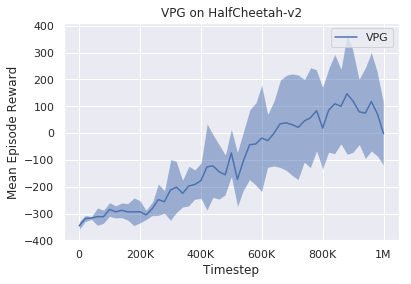

In [9]:
plot = CurvePlot()
plot.add('VPG', y_values, xvalues=x_values)
ax = plot(title=f'VPG on {env_id}', 
          xlabel='Timestep', 
          ylabel='Mean Episode Reward', 
          num_tick=6, 
          xscale_magnitude=None)

In [11]:
ax.figure.savefig('data/result.png')